In [223]:
import numpy as np
from scipy.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt


<Figure size 2000x1000 with 0 Axes>

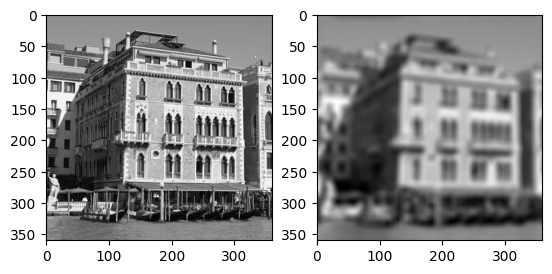

In [26]:
original_image = np.load('original_img.npy')
noisy_image = np.load('noisy_img.npy')

plt.figure(figsize=(20, 10))
fig, ax = plt.subplots(1, 2)
ax[0].imshow(original_image, cmap='grey')
ax[1].imshow(noisy_image, cmap='grey')

# Gaussian filtering

In [313]:
def gaussian_kernel(radius=3, sigma=1):
    kernel = np.exp(-np.sum((radius - np.indices((radius*2+1, radius*2+1)))**2, axis=0)/(2*sigma**2)) / (2*np.pi*sigma**2)
    return kernel / np.sum(kernel)

def inverse_kernel(kernel, threshold=1e-3):
    return np.where(np.abs(kernel) > threshold, 1/kernel, 0)

def inverse_filtering(image, kernel, threshold=1e-3):
    padded_kernel = ifftshift(np.pad(kernel, ((0, image.shape[0]-kernel.shape[0]), (0, image.shape[1]-kernel.shape[1]))))
    return fftshift(np.real(ifft2(fft2(image)*inverse_kernel(fft2(padded_kernel), threshold))))
    # return np.abs(ifft2(fft2(image)*inverse_kernel(fft2(kernel, image.shape), threshold)))

def wiener_filtering(image, kernel, K=1e-3):
    padded_kernel = ifftshift(np.pad(kernel, ((0, image.shape[0]-kernel.shape[0]), (0, image.shape[1]-kernel.shape[1]))))
    fft_kernel = fft2(padded_kernel)
    fft_kernel_conjugate = np.conjugate(fft_kernel)
    return fftshift(np.abs(ifft2( fft2(image)*( fft_kernel_conjugate/(fft_kernel*fft_kernel_conjugate + K) ) )))

<Figure size 3000x1000 with 0 Axes>

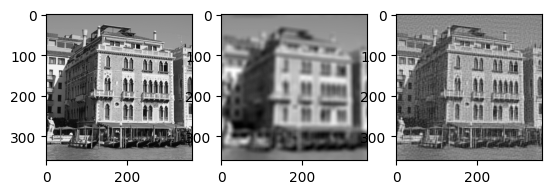

In [296]:
plt.figure(figsize=(30, 10))
fig, ax = plt.subplots(1, 3)
ax[0].imshow(original_image, cmap='grey')
ax[1].imshow(noisy_image, cmap='grey')
ax[2].imshow(inverse_filtering(noisy_image, gaussian_kernel(7, sigma=5), 5e-3), cmap='grey')

# Wiener Filtering

<Figure size 3000x1000 with 0 Axes>

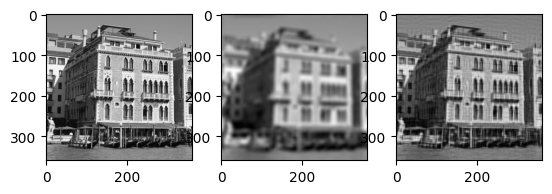

In [300]:
plt.figure(figsize=(30, 10))
fig, ax = plt.subplots(1, 3)
ax[0].imshow(original_image, cmap='grey')
ax[1].imshow(noisy_image, cmap='grey')
ax[2].imshow(wiener_filtering(noisy_image, gaussian_kernel(7, sigma=5), 3e-4), cmap='grey')

# Metrics

In [316]:
import optuna

def PSNR(original_image, image, max_pixel_value=255):
    return 20 * np.log10(max_pixel_value/np.mean((original_image.flatten()-image.flatten())**2))

def objective(trial):
    return PSNR(original_image, wiener_filtering(noisy_image, gaussian_kernel(7, sigma=5), trial.suggest_float('K', 1e-5, 1e-1)))

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=60)

[I 2025-06-08 15:03:12,116] A new study created in memory with name: no-name-e74db592-16b2-40c6-bb03-b5f396e0019f
[I 2025-06-08 15:03:12,145] Trial 0 finished with value: 83.97909272937028 and parameters: {'K': 0.03746026648354778}. Best is trial 0 with value: 83.97909272937028.
[I 2025-06-08 15:03:12,159] Trial 1 finished with value: 82.16316960651938 and parameters: {'K': 0.09507192349792752}. Best is trial 0 with value: 83.97909272937028.
[I 2025-06-08 15:03:12,166] Trial 2 finished with value: 82.79485932199125 and parameters: {'K': 0.0732020742417224}. Best is trial 0 with value: 83.97909272937028.
[I 2025-06-08 15:03:12,173] Trial 3 finished with value: 83.20162540708301 and parameters: {'K': 0.0598698618348617}. Best is trial 0 with value: 83.97909272937028.
[I 2025-06-08 15:03:12,180] Trial 4 finished with value: 85.20916522280322 and parameters: {'K': 0.01561030385783923}. Best is trial 4 with value: 85.20916522280322.
[I 2025-06-08 15:03:12,186] Trial 5 finished with value: 8

Best K: 0.00010434901513490989


<Figure size 3000x1000 with 0 Axes>

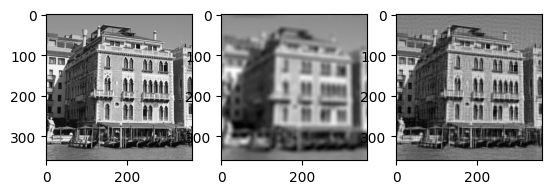

In [317]:
print("Best K:", study.best_params['K'])

plt.figure(figsize=(30, 10))
fig, ax = plt.subplots(1, 3)
ax[0].imshow(original_image, cmap='grey')
ax[1].imshow(noisy_image, cmap='grey')
ax[2].imshow(wiener_filtering(noisy_image, gaussian_kernel(7, sigma=5), study.best_params['K']), cmap='grey')